# Setup

In [1]:
from pathlib import Path
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# repo root finder (works whether notebook runs from repo root or /notebooks)
cwd = Path.cwd()
repo_root = next(p for p in [cwd, *cwd.parents] if (p/"data").exists() and (p/"tools").exists())
os.chdir(repo_root)
sys.path.append(str(repo_root))

from tools.io import load_prompt2_json
from tools.clean import clean_prompt2
from tools.modeling import fit_classification, fit_regression


RAW_PATH = repo_root / "data" / "raw" / "unh_hackathon_prompt_2_data.json"
CLEAN_PATH = repo_root / "data" / "processed" / "prompt2_clean.parquet"

# Load

In [ ]:
if CLEAN_PATH.exists():
    clean_df = pd.read_parquet(CLEAN_PATH)
    print("Loaded cleaned data")
else:
    df = load_prompt2_json(RAW_PATH)
    clean_df, report = clean_prompt2(df)
    CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)
    clean_df.to_parquet(CLEAN_PATH, index=False)
    print("Created cleaned data")

print(f"Shape: {clean_df.shape[0]} rows × {clean_df.shape[1]} columns")
display(clean_df.head(3))

Loaded cleaned parquet: /Users/michaelbanks/Desktop/Hackathon/UNH-Hackathon-Code/data/processed/prompt2_clean.parquet
Shape: (3000, 30)


,threat_type,enemy_unit_count,enemy_capability_index,threat_escalation_hours,friendly_unit_count,lcs_count,aircraft_count,cyber_defense_teams,patriot_batteries,isr_asset_count,...,roe_complexity,budget_musd,budget_utilization_pct,weather_severity,distance_to_theater_km,Season,response_success,Financial_Loss_MUSD,actual_days_to_stabilization,bad_success
0,missile,25,8,34,21,0,0,0,4,12,...,3,98,84,3,5164.8,winter,1,388,10.1,0
1,missile,3,2,8,45,0,0,0,4,4,...,5,189,97,1,7149.7,fall,1,244,2.0,0
2,air,7,3,48,45,0,5,0,0,14,...,1,92,88,0,6706.5,winter,1,280,2.0,0


# Targets

In [3]:
targets = ["response_success", "Financial_Loss_MUSD", "actual_days_to_stabilization"]
for t in targets:
    if t in clean_df.columns:
        print("\n==", t, "==")
        display(clean_df[t].describe(include="all"))

# response_success balance
if "response_success" in clean_df.columns:
    vc = clean_df["response_success"].value_counts(dropna=False)
    print("\nresponse_success value counts:\n", vc)


== response_success ==


count    3000.000000
mean        0.859667
std         0.347390
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: response_success, dtype: float64


== Financial_Loss_MUSD ==


count    3000.000000
mean      313.052333
std        86.397892
min        63.000000
25%       250.000000
50%       309.000000
75%       371.000000
max       658.000000
Name: Financial_Loss_MUSD, dtype: float64


== actual_days_to_stabilization ==


count    3000.000000
mean        9.355167
std         5.111685
min         2.000000
25%         5.400000
50%         8.950000
75%        12.800000
max        28.200000
Name: actual_days_to_stabilization, dtype: float64


response_success value counts:
 response_success
1    2579
0     421
Name: count, dtype: int64


# Helper Functions

In [4]:
def _success_rate_by_category(df: pd.DataFrame, cat_col: str, target_col="response_success", min_count=10):
    d = df.dropna(subset=[cat_col, target_col]).copy()
    # ensure target is 0/1
    d = d[d[target_col].isin([0, 1])]
    grp = d.groupby(cat_col)[target_col].agg(["mean", "count"]).rename(columns={"mean": "success_rate"})
    grp = grp[grp["count"] >= min_count].sort_values("success_rate")
    return grp

def _binned_success_rate(df: pd.DataFrame, num_col: str, bins=5, target_col="response_success"):
    d = df.dropna(subset=[num_col, target_col]).copy()
    d = d[d[target_col].isin([0, 1])]
    d["_bin"] = pd.qcut(d[num_col], q=bins, duplicates="drop")
    grp = d.groupby("_bin")[target_col].agg(["mean", "count"]).rename(columns={"mean": "success_rate"})
    return grp

def _barh_from_series(s: pd.Series, title: str, xlabel: str = ""):
    fig = plt.figure(figsize=(9, max(3, 0.35*len(s))))
    ax = fig.add_subplot(111)
    ax.barh(list(reversed(s.index.tolist())), list(reversed(s.values.tolist())))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()


# Success by Category


Success rate by threat_type (sorted low→high):


,success_rate,count
threat_type,,
hybrid,0.750000,572
missile,0.852732,421
naval,0.864516,775
cyber,0.887234,470
msl,0.904762,21
air,0.924426,741


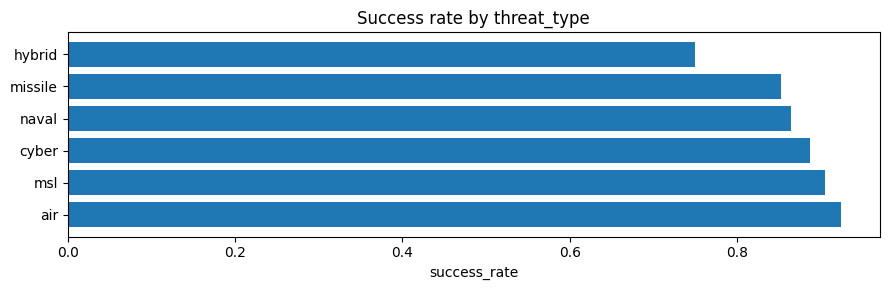


Success rate by Season (sorted low→high):


,success_rate,count
Season,,
summer,0.845638,745
winter,0.847044,778
spring,0.872870,763
fall,0.873950,714


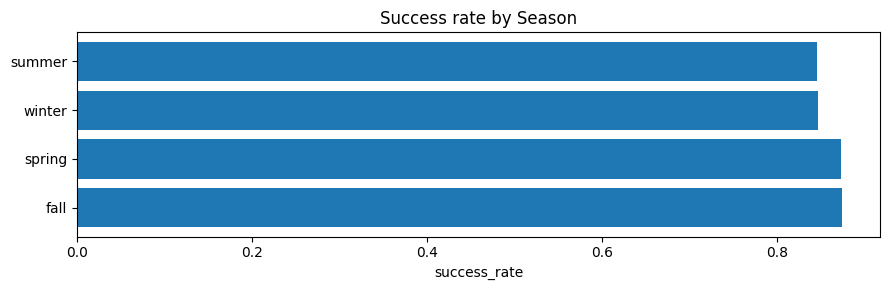

In [5]:
for col in ["threat_type", "Season"]:
    if col in clean_df.columns and "response_success" in clean_df.columns:
        tbl = _success_rate_by_category(clean_df, col, min_count=5)
        print(f"\nSuccess rate by {col} (sorted low→high):")
        display(tbl.head(25))
        _barh_from_series(tbl["success_rate"], title=f"Success rate by {col}", xlabel="success_rate")

# Which variables matter?

In [6]:
num_cols_to_check = ["readiness_level", "intel_confidence", "roe_complexity", "weather_severity", 
                     "enemy_unit_count", "friendly_unit_count", "budget_musd", "distance_to_theater_km",
                     "logistics_delay_hours"]

if "response_success" in clean_df.columns:
    for col in num_cols_to_check:
        if col in clean_df.columns:
            try:
                tbl = _binned_success_rate(clean_df, col, bins=5)
                print(f"\nBinned success rate by {col}:")
                display(tbl)
            except Exception as e:
                print(f"Skipping {col} (could not bin): {e}")


Binned success rate by readiness_level:


,success_rate,count
_bin,,
"(39.999, 53.0]",0.788976,635
"(53.0, 65.0]",0.853859,609
"(65.0, 76.0]",0.825480,573
"(76.0, 88.0]",0.888889,603
"(88.0, 100.0]",0.946552,580



Binned success rate by intel_confidence:


,success_rate,count
_bin,,
"(0.299, 0.44]",0.807131,617
"(0.44, 0.58]",0.834753,587
"(0.58, 0.72]",0.871383,622
"(0.72, 0.86]",0.885017,574
"(0.86, 1.0]",0.907826,575



Binned success rate by roe_complexity:


,success_rate,count
_bin,,
"(0.999, 2.0]",0.888525,1220
"(2.0, 3.0]",0.860068,586
"(3.0, 4.0]",0.822400,625
"(4.0, 5.0]",0.838313,569



Binned success rate by weather_severity:


,success_rate,count
_bin,,
"(-0.001, 2.0]",0.907784,835
"(2.0, 4.0]",0.887129,505
"(4.0, 6.0]",0.868231,554
"(6.0, 8.0]",0.817029,552
"(8.0, 10.0]",0.796029,554



Binned success rate by enemy_unit_count:


,success_rate,count
_bin,,
"(0.999, 11.0]",0.922961,662
"(11.0, 20.0]",0.878004,541
"(20.0, 31.0]",0.849612,645
"(31.0, 41.0]",0.843594,601
"(41.0, 50.0]",0.794918,551



Binned success rate by friendly_unit_count:


,success_rate,count
_bin,,
"(4.999, 16.0]",0.853168,647
"(16.0, 27.0]",0.851485,606
"(27.0, 38.0]",0.888696,575
"(38.0, 49.0]",0.862543,582
"(49.0, 60.0]",0.844068,590



Binned success rate by budget_musd:


,success_rate,count
_bin,,
"(49.999, 134.0]",0.877483,604
"(134.0, 229.6]",0.854027,596
"(229.6, 323.0]",0.859038,603
"(323.0, 410.2]",0.845896,597
"(410.2, 500.0]",0.861667,600



Binned success rate by distance_to_theater_km:


,success_rate,count
_bin,,
"(504.899, 2392.94]",0.891667,600
"(2392.94, 4325.06]",0.891667,600
"(4325.06, 6211.48]",0.860000,600
"(6211.48, 8142.28]",0.855000,600
"(8142.28, 9997.0]",0.800000,600



Binned success rate by logistics_delay_hours:


,success_rate,count
_bin,,
"(-0.001, 5.0]",0.886003,693
"(5.0, 10.0]",0.899023,614
"(10.0, 14.0]",0.844569,534
"(14.0, 19.0]",0.836039,616
"(19.0, 24.0]",0.823204,543


# Baseline Models

/Users/michaelbanks/Desktop/Hackathon/UNH-Hackathon-Code/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Classification: response_success ===
AUC: 0.9457


enemy_capability_index     0.202746
aircraft_count             0.042770
cyber_defense_teams        0.027344
readiness_level            0.021893
weather_severity           0.019145
threat_escalation_hours    0.018354
joint_force_integration    0.017804
isr_asset_count            0.011746
prior_engagements          0.011730
patriot_batteries          0.010286
lcs_count                  0.009224
intel_confidence           0.007093
enemy_unit_count           0.006047
logistics_delay_hours      0.004216
distance_to_theater_km     0.003719
dtype: float64

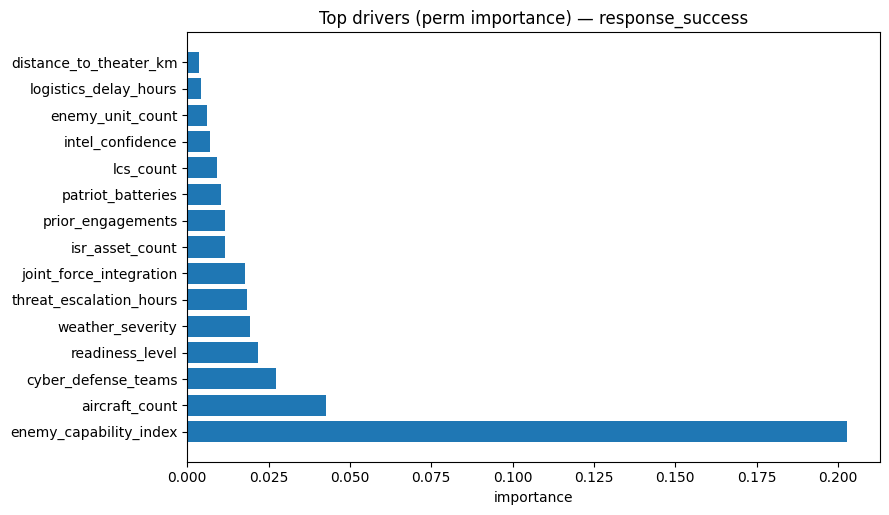


=== Regression: Financial_Loss_MUSD ===
MAE: 24.123


aircraft_count             27.185738
enemy_unit_count           20.368571
enemy_capability_index     20.228178
response_time_hrs          15.814726
lcs_count                  15.473458
isr_asset_count            13.138327
logistics_delay_hours      11.379480
distance_to_theater_km      6.164286
patriot_batteries           3.520994
cyber_defense_teams         2.161150
readiness_level             0.544418
threat_escalation_hours     0.487444
joint_force_integration     0.467093
supply_chain_resilience     0.455885
intel_confidence            0.217333
dtype: float64

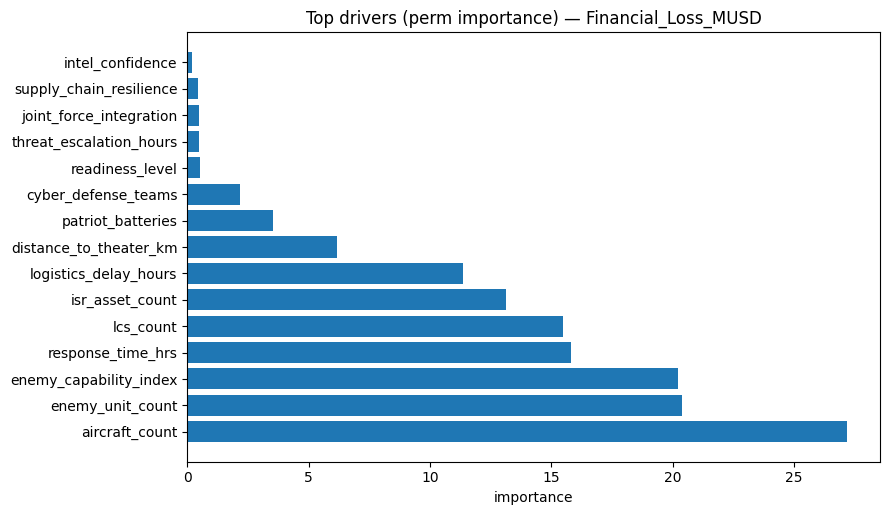


=== Regression: actual_days_to_stabilization ===
MAE: 1.4503


logistics_delay_hours       2.695930
threat_type                 1.397640
cmd_coord_score             0.776994
joint_force_integration     0.669395
prior_engagements           0.502532
isr_asset_count             0.371056
enemy_capability_index      0.165185
satellite_coverage_score    0.102456
patriot_batteries           0.035616
aircraft_count              0.035531
readiness_level             0.025961
weather_severity            0.022448
lcs_count                   0.021454
EW_Capability               0.018435
enemy_unit_count            0.017132
dtype: float64

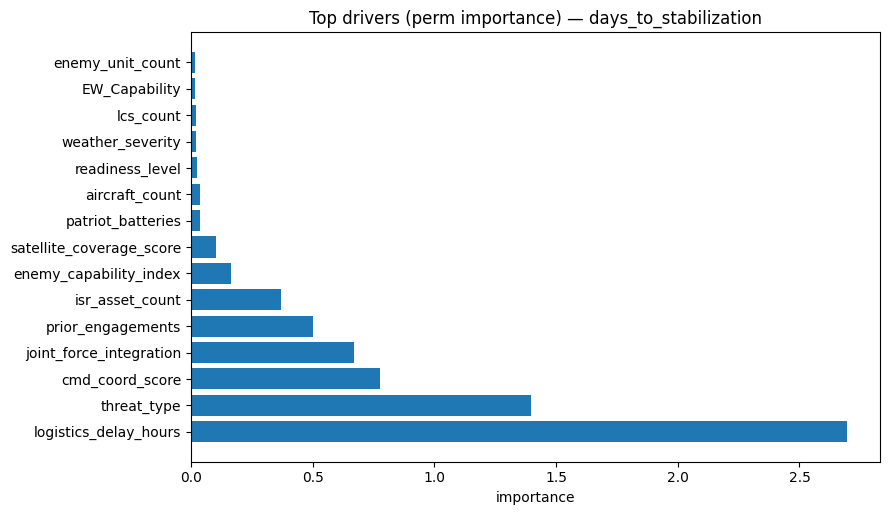

In [7]:
if "response_success" in clean_df.columns:
    pipe_cls, metrics_cls = fit_classification(clean_df, target="response_success", random_state=42)
    print("\n=== Classification: response_success ===")
    print("AUC:", round(metrics_cls["auc"], 4))
    imp_cls = metrics_cls["perm_importance"].head(15)
    display(imp_cls)
    _barh_from_series(imp_cls.sort_values(), title="Top drivers (perm importance) — response_success", xlabel="importance")

# 2) Financial_Loss_MUSD regression
if "Financial_Loss_MUSD" in clean_df.columns:
    pipe_loss, metrics_loss = fit_regression(clean_df, target="Financial_Loss_MUSD", random_state=123)
    print("\n=== Regression: Financial_Loss_MUSD ===")
    print("MAE:", round(metrics_loss["mae"], 4))
    imp_loss = metrics_loss["perm_importance"].head(15)
    display(imp_loss)
    _barh_from_series(imp_loss.sort_values(), title="Top drivers (perm importance) — Financial_Loss_MUSD", xlabel="importance")

# 3) actual_days_to_stabilization regression
if "actual_days_to_stabilization" in clean_df.columns:
    pipe_days, metrics_days = fit_regression(clean_df, target="actual_days_to_stabilization", random_state=456)
    print("\n=== Regression: actual_days_to_stabilization ===")
    print("MAE:", round(metrics_days["mae"], 4))
    imp_days = metrics_days["perm_importance"].head(15)
    display(imp_days)
    _barh_from_series(imp_days.sort_values(), title="Top drivers (perm importance) — days_to_stabilization", xlabel="importance")


# Summary 

In [8]:
def top_features(series: pd.Series, n=10):
    return series.head(n).to_frame("importance")

print("\n\n==== Top drivers summary (top 10) ====")
if "response_success" in clean_df.columns:
    print("\nresponse_success:")
    display(top_features(metrics_cls["perm_importance"], 10))
if "Financial_Loss_MUSD" in clean_df.columns:
    print("\nFinancial_Loss_MUSD:")
    display(top_features(metrics_loss["perm_importance"], 10))
if "actual_days_to_stabilization" in clean_df.columns:
    print("\nactual_days_to_stabilization:")
    display(top_features(metrics_days["perm_importance"], 10))



==== Top drivers summary (top 10) ====

response_success:


,importance
enemy_capability_index,0.202746
aircraft_count,0.042770
cyber_defense_teams,0.027344
readiness_level,0.021893
weather_severity,0.019145
threat_escalation_hours,0.018354
joint_force_integration,0.017804
isr_asset_count,0.011746
prior_engagements,0.011730
patriot_batteries,0.010286



Financial_Loss_MUSD:


,importance
aircraft_count,27.185738
enemy_unit_count,20.368571
enemy_capability_index,20.228178
response_time_hrs,15.814726
lcs_count,15.473458
isr_asset_count,13.138327
logistics_delay_hours,11.379480
distance_to_theater_km,6.164286
patriot_batteries,3.520994
cyber_defense_teams,2.161150



actual_days_to_stabilization:


,importance
logistics_delay_hours,2.695930
threat_type,1.397640
cmd_coord_score,0.776994
joint_force_integration,0.669395
prior_engagements,0.502532
isr_asset_count,0.371056
enemy_capability_index,0.165185
satellite_coverage_score,0.102456
patriot_batteries,0.035616
aircraft_count,0.035531
